In [36]:
import torch as T
import torchvision as TV
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# load data and check images

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [41]:
batch_size = 16
train_dataset = TV.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = TV.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [43]:
def show_image(img):
    img = img /2 + 0.5 # unnormalize
    npimg = img.numpy() # to array
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
data_iter = iter(train_dataloader) # to a generator
images, labels = data_iter.next()

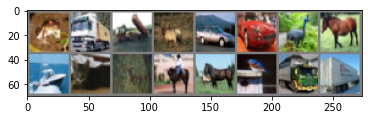

frog truck truck deer car car bird horse ship cat deer horse horse bird truck truck


In [44]:
show_image(TV.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(batch_size)))

# set up cuda 

In [45]:
device = T.device("cuda:0") if T.cuda.is_available() else "cpu"
print(device, type(device))

cuda:0 <class 'torch.device'>


# create model of CNN

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class CovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = T.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
model = CovNet()
model.to(device)
        

CovNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# loss function

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = T.optim.AdamW(model.parameters(), lr=0.001)

# training step

In [49]:
for epoch in range(2):
    running_loss = 0.0 
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
            
print("Finished Training")

[1,  1000] loss: 0.635
[1,  2000] loss: 0.616
[1,  3000] loss: 0.609
[2,  1000] loss: 0.576
[2,  2000] loss: 0.557
[2,  3000] loss: 0.558
Finished Training


In [50]:
PATH = os.path.join("./cifar_net.pth")
T.save(model.state_dict(), PATH)

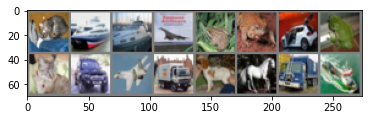

Ground Truth: cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship


In [51]:
data_iter = iter(test_dataloader)
images, labels = data_iter.next()

show_image(TV.utils.make_grid(images))
print("Ground Truth:", " ".join(f"{classes[labels[j]]}" for j in range(batch_size)))